In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import typing
import warnings
import typing_extensions as tx
import numpy as np
import tensorflow_addons as tfa
import glob, warnings
import imageio
from tensorflow import keras
from joblib import Parallel, delayed
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-10-24 18:42:43.852834: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 18:42:43.944953: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 18:42:44.431755: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/kannika/miniconda3/envs/tfNetV2/lib/
2024-10-24 18:42:44.431805: W tensorflow/co

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
## input_shape get from EfficienNet-B5
input_shape = (456, 456, 3)
print(input_shape)

(456, 456, 3)


## 📂 Import Dataset

In [5]:
dataset = pd.read_csv("/home/kannika/codes_AI/CSV/mini-ImageNet_MachineUnlearn.csv", dtype=str)
print(dataset.shape)
dataset.head()

(60000, 6)


,Unnamed: 0,img_path,filename,label,cls,subset
0,0,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700001135.jpg,n04443257,TRUE,train
1,1,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000414.jpg,n04443257,TRUE,train
2,2,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000025.jpg,n04443257,TRUE,train
3,3,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000324.jpg,n04443257,TRUE,train
4,4,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000491.jpg,n04443257,TRUE,train


In [6]:
set(dataset['subset'])

{'test', 'train', 'val'}

In [7]:
TESTdf = dataset[dataset["subset"]=='test'].reset_index(drop=True)
print(TESTdf.shape)
TESTdf.head()

(6000, 6)


,Unnamed: 0,img_path,filename,label,cls,subset
0,270,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000402.jpg,n04443257,TRUE,test
1,271,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700001200.jpg,n04443257,TRUE,test
2,272,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000584.jpg,n04443257,TRUE,test
3,273,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000311.jpg,n04443257,TRUE,test
4,274,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000037.jpg,n04443257,TRUE,test


- TRUE  ==> 1

- FALSE ==> 0

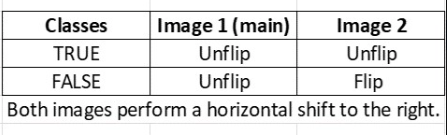

In [8]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(TESTdf.cls)
TESTdf['Encode_label'] = le.transform(TESTdf.cls)
TESTdf

,Unnamed: 0,img_path,filename,label,cls,subset,Encode_label
0,270,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000402.jpg,n04443257,TRUE,test,1
1,271,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700001200.jpg,n04443257,TRUE,test,1
2,272,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000584.jpg,n04443257,TRUE,test,1
3,273,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000311.jpg,n04443257,TRUE,test,1
4,274,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0444325700000037.jpg,n04443257,TRUE,test,1
...,...,...,...,...,...,...,...
5995,59995,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000771.jpg,n03838899,FALSE,test,0
5996,59996,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000066.jpg,n03838899,FALSE,test,0
5997,59997,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000604.jpg,n03838899,FALSE,test,0
5998,59998,/media/HDD/mini-ImageNet/mini-imagenet/train/n...,n0383889900000030.jpg,n03838899,FALSE,test,0


In [9]:
print(TESTdf['Encode_label'].value_counts())

1    3000
0    3000
Name: Encode_label, dtype: int64


In [10]:
TESTdf['filename'][0].split(".")[0]

'n0444325700000402'

## Image augmentation for classification

In [11]:
def batch_datagen(df, input_shape, BATCH_SIZE):
    '''
    df         : dataFrame train set, or ,test set
    input_shape: input_shape from EffNet-B5 model
    BATCH_SIZE : batch fro call data to train each epoch 
    '''
    #####***Augmeantation: main batch
    batch_datagen_main = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=30,
                      width_shift_range=0.2,
                      height_shift_range=0.2)

    batch_generator_main = batch_datagen_main.flow_from_dataframe(
                            dataframe = df,
                            directory = None,
                            x_col = 'img_path',
                            y_col = None,
                            target_size = (input_shape[0], input_shape[1]),
                            batch_size=BATCH_SIZE,
                            color_mode= 'rgb',
                            class_mode= None,
                            seed=32,
                            shuffle=False)

    #####***Augmeantation: batch 2
    batch_datagen_2 = ImageDataGenerator(
                      rescale=1./255,
                      rotation_range=50,
                      width_shift_range=0.5,
                      height_shift_range=0.5)

    batch_generator_2 = batch_datagen_2.flow_from_dataframe(
                        dataframe = df,
                        directory = None,
                        x_col = 'img_path',
                        y_col = 'cls',
                        target_size = (input_shape[0], input_shape[1]),
                        batch_size=BATCH_SIZE,
                        color_mode= 'rgb',
                        class_mode='binary',
                        seed=32,
                        shuffle=False)
    
    return batch_generator_main, batch_generator_2

## Aug: Flip_generator with Label (all Batch)

In [12]:
def Flip_generator_test(batch_generator_main, batch_generator_2, IMAGE_SIZE):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        batch_x, batch_y = next(batch_generator_2)
        batch_indices = batch_generator_2.batch_index * batch_generator_2.batch_size
        filenames2 = batch_generator_2.filenames[batch_indices:batch_indices + len(batch_x)]
        
        batch_x_main = next(batch_generator_main)
        batchX_indices = batch_generator_main.batch_index * batch_generator_main.batch_size
        filenamesX = batch_generator_main.filenames[batchX_indices:batchX_indices + len(batch_x_main)]
        
        batch_Flip = np.zeros((batch_x.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_main = np.zeros((batch_x_main.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
        batch_label = np.zeros((batch_y.shape[0], ))
        for i in range(batch_x.shape[0]):
            if batch_y[i] == 0.0:
                batch_Flip[i] = tf.image.flip_left_right(batch_x[i]) 
                batch_main[i] = batch_x_main[i] 
                batch_label[i] = batch_y[i]
            else:
                batch_Flip[i] = batch_x[i] 
                batch_main[i] = batch_x_main[i] 
                batch_label[i] = batch_y[i]
    
        yield ([batch_main, batch_Flip], batch_label, filenamesX, filenames2)

> ## Test set

In [13]:
batch_generator_main, batch_generator_2 = batch_datagen(TESTdf, input_shape, BATCH_SIZE=16)

Found 6000 validated image filenames.
Found 6000 validated image filenames belonging to 2 classes.


In [14]:
batch_testv2 = Flip_generator_test(batch_generator_main, batch_generator_2, IMAGE_SIZE=input_shape[0])

In [16]:
import cv2

image_main_tranform, image_2_tranform = [], []
name_main_tranform, name_2_tranform = [], []
encode_label, cls_ = [], []
basepath = "/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2"
# Create the folder
os.makedirs(basepath, exist_ok=True) 
# Get total number of batches
total_batches = batch_generator_main.n // batch_generator_main.batch_size

# Iterate through batches
batch_count = 0
while batch_count < total_batches:
    batchv2 = next(batch_testv2)
    batch_count += 1
    print(f"Processed batch {batch_count} of {total_batches}")
    for i in range(len(batchv2[1])):
        image_array_main = batchv2[0][0][i]
        image_array_batch2 = batchv2[0][1][i]
        label_i = batchv2[1][i]
        
        ## save Images >>> main image
        filename = batchv2[2][i].split("/")[-1]
        filename = filename.split(".")[0]
        pathimage_main = f"{basepath}/{filename}_batchmain.jpg"
        # If the image is in float format, scale it to 0-255 and convert to uint8
        if image_array_main.max() <= 1.0:
            image_array_main = (image_array_main * 255).astype(np.uint8)
        cv2.imwrite(pathimage_main, image_array_main)
        
        ## save Images >>> image batch 2
        filename_batch2 = batchv2[3][i].split("/")[-1]
        filename_batch2 = filename_batch2.split(".")[0]
        pathimage_batch2 = f"{basepath}/{filename_batch2}_batch2.jpg"
        # If the image is in float format, scale it to 0-255 and convert to uint8
        if image_array_batch2.max() <= 1.0:
            image_array_batch2 = (image_array_batch2 * 255).astype(np.uint8)
        cv2.imwrite(pathimage_batch2, image_array_batch2)
        
        ### Append to List
        image_main_tranform.append(pathimage_main)
        image_2_tranform.append(pathimage_batch2)
        name_main_tranform.append(filename)
        name_2_tranform.append(filename_batch2)
        encode_label.append(int(label_i))
        if label_i == 1:
            cls  = "TRUE"
        else:
            cls  = "FALSE"
            
        cls_.append(cls)

2024-10-24 18:44:15.817452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 18:44:16.271502: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 495 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5


Processed batch 1 of 375
Processed batch 2 of 375
Processed batch 3 of 375
Processed batch 4 of 375
Processed batch 5 of 375
Processed batch 6 of 375
Processed batch 7 of 375
Processed batch 8 of 375
Processed batch 9 of 375
Processed batch 10 of 375
Processed batch 11 of 375
Processed batch 12 of 375
Processed batch 13 of 375
Processed batch 14 of 375
Processed batch 15 of 375
Processed batch 16 of 375
Processed batch 17 of 375
Processed batch 18 of 375
Processed batch 19 of 375
Processed batch 20 of 375
Processed batch 21 of 375
Processed batch 22 of 375
Processed batch 23 of 375
Processed batch 24 of 375
Processed batch 25 of 375
Processed batch 26 of 375
Processed batch 27 of 375
Processed batch 28 of 375
Processed batch 29 of 375
Processed batch 30 of 375
Processed batch 31 of 375
Processed batch 32 of 375
Processed batch 33 of 375
Processed batch 34 of 375
Processed batch 35 of 375
Processed batch 36 of 375
Processed batch 37 of 375
Processed batch 38 of 375
Processed batch 39 of

Processed batch 309 of 375
Processed batch 310 of 375
Processed batch 311 of 375
Processed batch 312 of 375
Processed batch 313 of 375
Processed batch 314 of 375
Processed batch 315 of 375
Processed batch 316 of 375
Processed batch 317 of 375
Processed batch 318 of 375
Processed batch 319 of 375
Processed batch 320 of 375
Processed batch 321 of 375
Processed batch 322 of 375
Processed batch 323 of 375
Processed batch 324 of 375
Processed batch 325 of 375
Processed batch 326 of 375
Processed batch 327 of 375
Processed batch 328 of 375
Processed batch 329 of 375
Processed batch 330 of 375
Processed batch 331 of 375
Processed batch 332 of 375
Processed batch 333 of 375
Processed batch 334 of 375
Processed batch 335 of 375
Processed batch 336 of 375
Processed batch 337 of 375
Processed batch 338 of 375
Processed batch 339 of 375
Processed batch 340 of 375
Processed batch 341 of 375
Processed batch 342 of 375
Processed batch 343 of 375
Processed batch 344 of 375
Processed batch 345 of 375
P

In [17]:
print(len(image_main_tranform))
print(len(image_2_tranform))
print(len(name_main_tranform))
print(len(name_2_tranform))
print(len(encode_label))
print(len(cls_))

6000
6000
6000
6000
6000
6000


In [25]:
df = pd.DataFrame({'filename': name_main_tranform, 'img_path_main': image_main_tranform, 'img_path_2': image_2_tranform,
                      'cls':cls_, 'encode_label':encode_label })
df["subset"] = "test"
print(df.shape)
df

(6000, 6)


,filename,img_path_main,img_path_2,cls,encode_label,subset
0,n0444325700001113,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
1,n0444325700000041,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
2,n0444325700000976,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
3,n0444325700000294,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
4,n0444325700000506,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
...,...,...,...,...,...,...
5995,n0444325700000026,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
5996,n0444325700000332,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
5997,n0444325700000705,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test
5998,n0444325700000354,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,/media/HDD/mini-ImageNet/mini-imagenet-DATATES...,TRUE,1,test


In [29]:
df.to_csv("/home/kannika/codes_AI/CSV/DATATEST-V2_mini_ImageNet_MachineUnlearn.csv")

- TRUE  ==> 1

- FALSE ==> 0

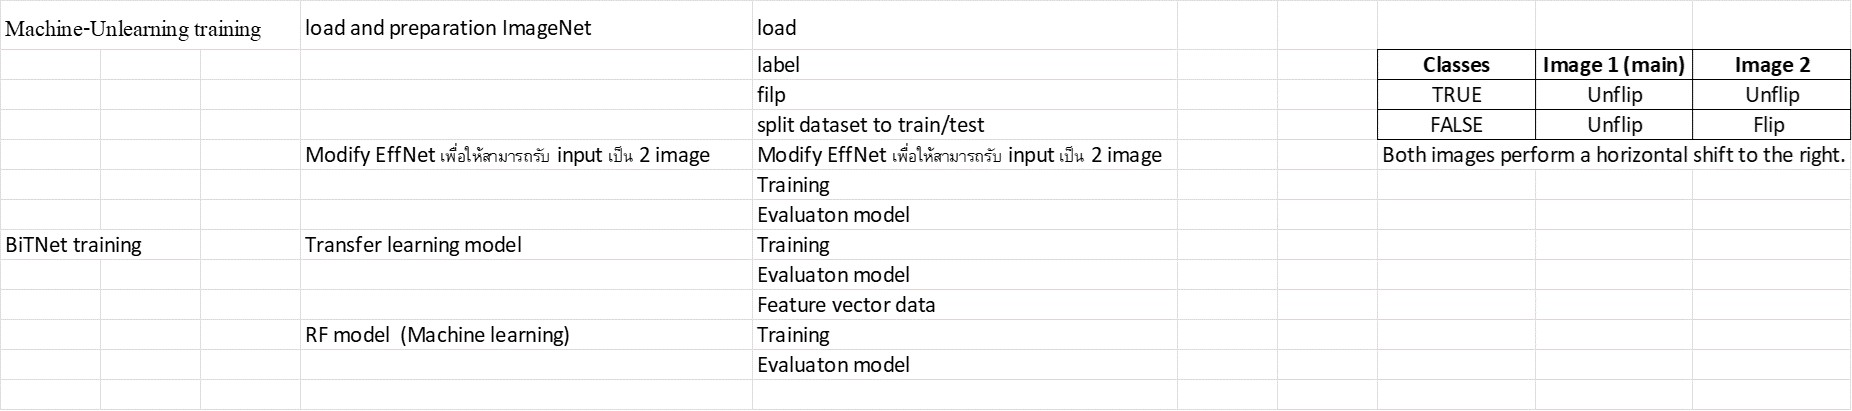

<Figure size 1200x1200 with 0 Axes>

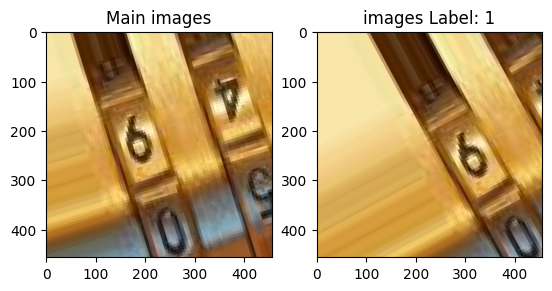

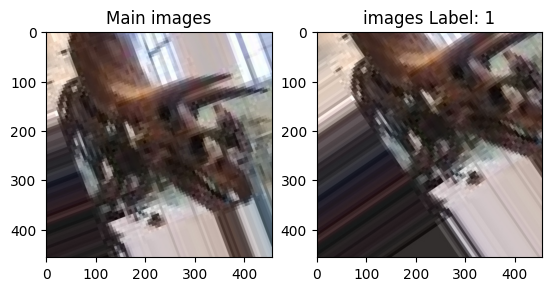

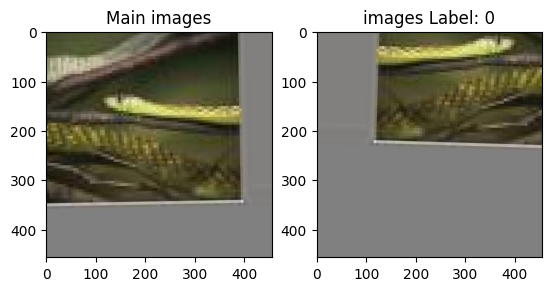

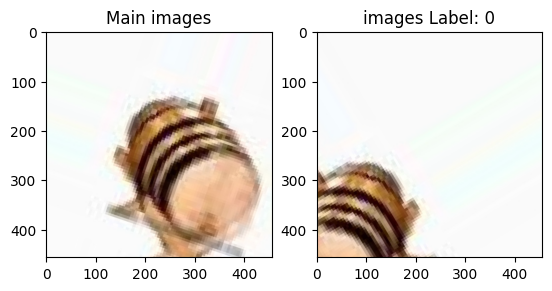

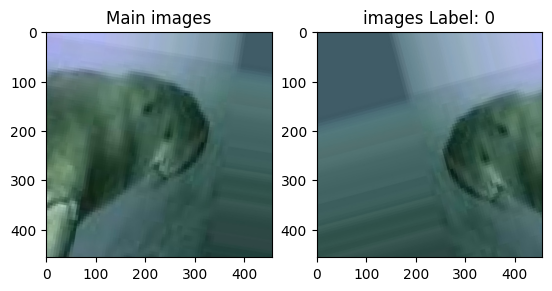

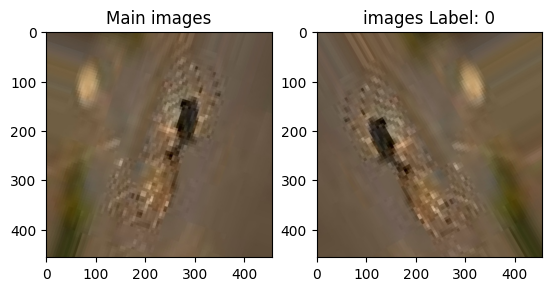

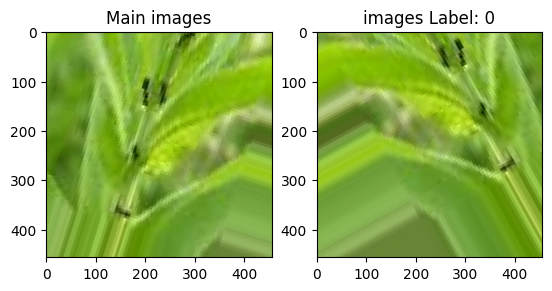

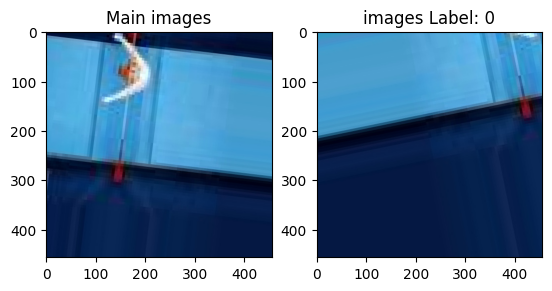

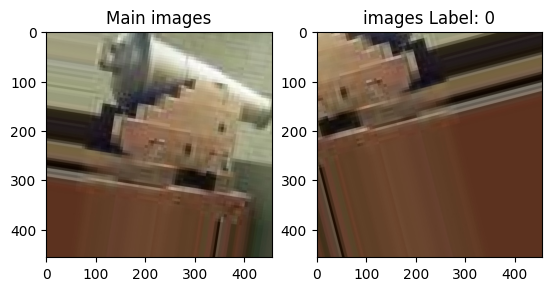

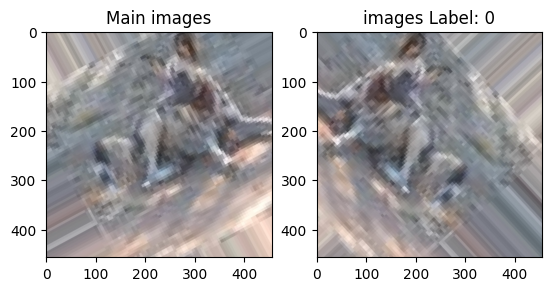

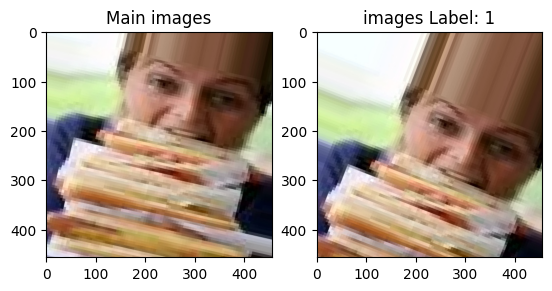

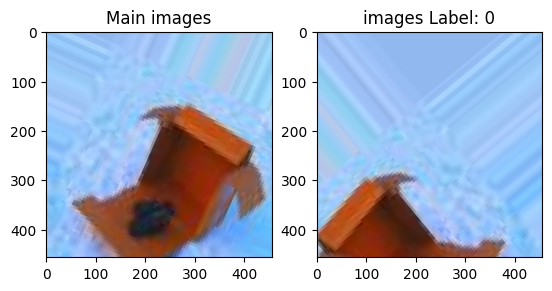

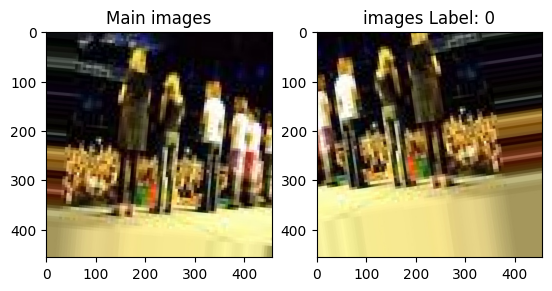

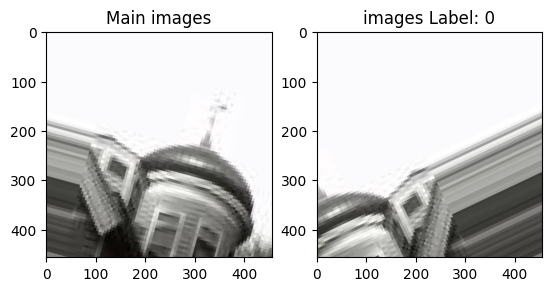

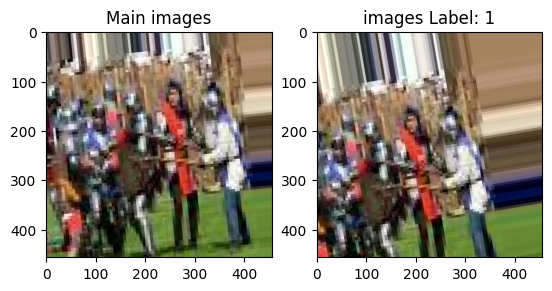

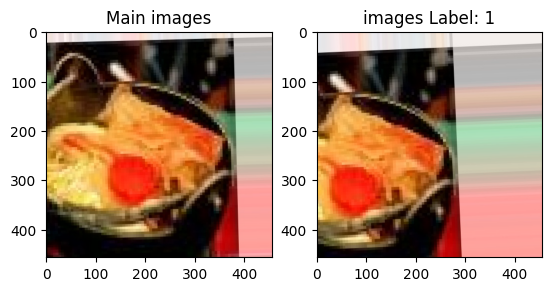

In [28]:
import cv2 
import PIL
from PIL import Image

%matplotlib inline
from matplotlib import pyplot as plt

randomdf = df.sample(16, replace=False)
batchXmain_train = randomdf['img_path_main'].tolist() 
batchX2_train = randomdf['img_path_2'].tolist()
batchY_train = randomdf['encode_label'].tolist()

fig = plt.figure(figsize=(12, 12))
for i in range(len(randomdf)):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    array_imgMain = cv2.imread(batchXmain_train[i])
    array_img2 = cv2.imread(batchX2_train[i])
    
    ax1.imshow(array_imgMain)
    ax1.set_title("Main images")
    ax2.imshow(array_img2)
    ax2.set_title(f"images Label: {int(batchY_train[i])}")
    plt.show()

In [30]:
array_imgMain

array([[[243, 233, 226],
        [243, 233, 226],
        [243, 231, 227],
        ...,
        [244, 239, 236],
        [244, 239, 236],
        [244, 239, 236]],

       [[243, 233, 226],
        [243, 233, 226],
        [243, 231, 227],
        ...,
        [244, 239, 236],
        [244, 239, 236],
        [244, 239, 236]],

       [[243, 233, 226],
        [243, 233, 226],
        [243, 231, 227],
        ...,
        [244, 239, 236],
        [244, 239, 236],
        [244, 239, 236]],

       ...,

       [[  6,   2,   1],
        [  7,   2,   1],
        [  6,   1,   0],
        ...,
        [230, 154, 155],
        [230, 154, 155],
        [230, 154, 155]],

       [[  4,   2,   1],
        [  5,   3,   2],
        [  6,   2,   1],
        ...,
        [229, 155, 153],
        [229, 155, 153],
        [229, 155, 153]],

       [[  1,   2,   0],
        [  2,   3,   1],
        [  5,   1,   0],
        ...,
        [229, 155, 153],
        [229, 155, 153],
        [229, 155, 153]]

In [26]:
df['img_path_main'].tolist()

['/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700001113_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000041_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000976_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000294_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000506_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000704_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000005_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000793_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000909_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000365_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000883_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0

In [27]:
df['img_path_2'].tolist()

['/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700001113_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000041_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000976_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000294_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000506_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000704_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000005_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000793_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000909_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000365_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000883_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000004_batch2.jpg',
 '/m

In [18]:
image_main_tranform

['/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700001113_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000041_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000976_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000294_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000506_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000704_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000005_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000793_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000909_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000365_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000883_batchmain.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0

In [19]:
image_2_tranform

['/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700001113_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000041_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000976_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000294_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000506_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000704_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000005_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000793_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000909_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000365_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000883_batch2.jpg',
 '/media/HDD/mini-ImageNet/mini-imagenet-DATATESTV2/n0444325700000004_batch2.jpg',
 '/m

In [20]:
name_main_tranform

['n0444325700001113',
 'n0444325700000041',
 'n0444325700000976',
 'n0444325700000294',
 'n0444325700000506',
 'n0444325700000704',
 'n0444325700000005',
 'n0444325700000793',
 'n0444325700000909',
 'n0444325700000365',
 'n0444325700000883',
 'n0444325700000004',
 'n0444325700001027',
 'n0444325700000753',
 'n0444325700001110',
 'n0444325700001172',
 'n0444325700000505',
 'n0444325700001131',
 'n0444325700000122',
 'n0444325700000392',
 'n0444325700000534',
 'n0444325700000408',
 'n0444325700000635',
 'n0444325700000784',
 'n0444325700000102',
 'n0444325700000264',
 'n0444325700000170',
 'n0444325700000288',
 'n0429656200000307',
 'n0429656200000853',
 'n0429656200000271',
 'n0429656200001055',
 'n0429656200000570',
 'n0429656200000121',
 'n0429656200001130',
 'n0429656200000297',
 'n0429656200000531',
 'n0429656200000549',
 'n0429656200000941',
 'n0429656200000889',
 'n0429656200000624',
 'n0429656200001219',
 'n0429656200000683',
 'n0429656200001170',
 'n0429656200000462',
 'n0429656

In [21]:
name_2_tranform

['n0444325700001113',
 'n0444325700000041',
 'n0444325700000976',
 'n0444325700000294',
 'n0444325700000506',
 'n0444325700000704',
 'n0444325700000005',
 'n0444325700000793',
 'n0444325700000909',
 'n0444325700000365',
 'n0444325700000883',
 'n0444325700000004',
 'n0444325700001027',
 'n0444325700000753',
 'n0444325700001110',
 'n0444325700001172',
 'n0444325700000505',
 'n0444325700001131',
 'n0444325700000122',
 'n0444325700000392',
 'n0444325700000534',
 'n0444325700000408',
 'n0444325700000635',
 'n0444325700000784',
 'n0444325700000102',
 'n0444325700000264',
 'n0444325700000170',
 'n0444325700000288',
 'n0429656200000307',
 'n0429656200000853',
 'n0429656200000271',
 'n0429656200001055',
 'n0429656200000570',
 'n0429656200000121',
 'n0429656200001130',
 'n0429656200000297',
 'n0429656200000531',
 'n0429656200000549',
 'n0429656200000941',
 'n0429656200000889',
 'n0429656200000624',
 'n0429656200001219',
 'n0429656200000683',
 'n0429656200001170',
 'n0429656200000462',
 'n0429656

In [22]:
encode_label

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [23]:
cls_

['TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'TRUE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'FALSE',
 'TR